In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
def set_device():
    """
    Set the device. CUDA if available, otherwise CPU.
    
    Args: None
    
    Returns: Nothing   
    """
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("This notebook will be running on CPU!")
    else: 
        print("You have CUDA set up! Woohoo!!!")
        
    return device

In [4]:
# SEED = 2023
# set_seed(seed=SEED)
DEVICE = set_device()

You have CUDA set up! Woohoo!!!


In [5]:
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
          
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [6]:
basal_ganglia_regions = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
visual_cortex_regions = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]

total_vc_neurons=0
total_bg_neurons=0

sessions_to_use = []  ##Session indices
session_lengths = []  ##The number of trials in each session
input_visual_tensor_list = []
label_basal_tensor_list = []

for session in range(len(alldat)):
  num_vis_neurons = 0
  num_basal_neurons = 0
  vis_neuron_indices = []
  basal_neuron_indices = []
  for neuron_idx, area in enumerate(alldat[session]['brain_area']):
    if area in visual_cortex_regions:  ## Viusal areas
      num_vis_neurons += 1
      vis_neuron_indices.append(neuron_idx)
    if area in basal_ganglia_regions:  ## Basal Ganglia
      num_basal_neurons += 1
      basal_neuron_indices.append(neuron_idx)
          
  trial_num = alldat[session]['spks'].shape[1]   
  input_visual_recordings = np.empty((num_vis_neurons, trial_num, 250))
  label_basal_recordings = np.empty((num_basal_neurons, trial_num, 250))
  
  
  if num_vis_neurons*num_basal_neurons != 0:
    sessions_to_use.append(session)
    print("session " ,session, "has both visual and basal!")
    print('The name of the mouse: ' + alldat[session]['mouse_name'])
    print('The session time' + alldat[session]['date_exp'])
    print(alldat[session]['spks'].shape)

    print('The number of neurons being recorded:', len(alldat[session]['spks']))
    print('Number of visual neurons: ', num_vis_neurons)
    # print('Indices of visual neurons: ', vis_neuron_indices)
    
    ## To extract the data from alldat[current_session]
    for i, v in enumerate(vis_neuron_indices): 
      input_visual_recordings[i, :, :] = alldat[session]['spks'][v, :, :]
    print("reorganized visual activities for input: ", input_visual_recordings.shape)
    print('Number of basal neurons: ', num_basal_neurons)
    # print('Indices of basal neurons: ', basal_neuron_indices)
    for i, g in enumerate(basal_neuron_indices):
      label_basal_recordings[i, :, :] = alldat[session]['spks'][g, :, :]
    print("reorganized basal activities for label", label_basal_recordings.shape)
    print('----------------------------------------------------')
    
    visual_input_tensor = torch.from_numpy(input_visual_recordings).reshape(-1, 250)
    input_visual_tensor_list.append(visual_input_tensor)
    basal_label_tensor = torch.from_numpy(label_basal_recordings).reshape(-1, 250)
    label_basal_tensor_list.append(basal_label_tensor)

# input = torch.cat(input_visual_tensor_list, axis = 0)
# label = torch.cat(label_basal_tensor_list, axis = 0)
# !!!!!! I realized that the firing rate across different sessions have huge variations, so it may not be a good idea to combine them together!!!!!\

print("input tensor list: We have", len(input_visual_tensor_list), "and their shapes are ", [input_visual_tensor_list[i].shape for i in range(len(input_visual_tensor_list))])
print("label tensor list: We have", len(label_basal_tensor_list), "and their shapes are", [label_basal_tensor_list[i].shape for i in range(len(label_basal_tensor_list))])


session  0 has both visual and basal!
The name of the mouse: Cori
The session time2016-12-14
(734, 214, 250)
The number of neurons being recorded: 734
Number of visual neurons:  178
reorganized visual activities for input:  (178, 214, 250)
Number of basal neurons:  139
reorganized basal activities for label (139, 214, 250)
----------------------------------------------------
session  3 has both visual and basal!
The name of the mouse: Forssmann
The session time2017-11-01
(1769, 249, 250)
The number of neurons being recorded: 1769
Number of visual neurons:  120
reorganized visual activities for input:  (120, 249, 250)
Number of basal neurons:  435
reorganized basal activities for label (435, 249, 250)
----------------------------------------------------
session  7 has both visual and basal!
The name of the mouse: Hench
The session time2017-06-15
(1156, 250, 250)
The number of neurons being recorded: 1156
Number of visual neurons:  111
reorganized visual activities for input:  (111, 250,

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [7]:
### 2024/07/15 We set the turncation threshold to be 50 neurons
## adding reshape methods -- please go over the code to see if modified/added "aspects" are consistent 
## and do what they are intended to do, the number of neurons went down (perhaps a little bit more than intended)
## and the same for the trial number, but now they match in dimensions

import torch 
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    """
    I tried to make it tailored to our needs.
    It only considers sessions that have both visual and basal ganglia recordings.
    It only considers go trials.
    When indexed, it returns basal ganglia spikes and action).
    """

    def __init__(
        self,
        data,
        visual_cortex_regions: list = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # Put them as default argument so they can be easily changed if we decide to change areas
        basal_ganglia_regions: list = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],
        thresh=50
    ) -> None:
        
        self.visual_cortex_regions = visual_cortex_regions
        self.basal_ganglia_regions = basal_ganglia_regions
        self.thresh=thresh
        self.data = self.visual_and_basal(data)
        self.data = self.get_go_trials(self.data)
        self.min_trials, self.min_neurons = self.find_min_dimensions(self.data) # new 
        print(f"Minimum number of trials: {self.min_trials}")
        print(f"Minimum number of neurons: {self.thresh}")

    def __getitem__(
        self,
        session_index: int
    ) -> torch.tensor:
        
        session = self.data[session_index]
        
        # Since we don't need the visual spks so I am commentting this out. (YD, 07/16)
        # spikes_visual = self.get_truncated_spikes(session, self.visual_cortex_regions)
        
        ## Some number checks by Yangdong 24/7/15
        ## print("the shape of spikes_visual after truncating:", spikes_visual.shape)

        input_basal_spks = self.get_truncated_spikes(session, self.basal_ganglia_regions) # This will be the input data (time, trials, eurons_indicies)          
        label_action = torch.tensor(session['response'][0:self.min_trials]) #(-1: the mouse is turning the wheel to the left, which indicates that the mouse thinks the right side has higher contrast level. )
        
        return input_basal_spks, label_action

    def __len__(self):
      return len(self.data)

    def visual_and_basal(
        self,
        data: np.array
    ) -> list:
        """
        It checks whether any of the considered brain areas recorded in the session
        is present in both visual or basal regions.
        Also excludes sessions with a number of neurons < self.threshold
        """
      
        visual_and_basal_sessions = []
        for session in data:
        
            visual_ok = any(area in self.visual_cortex_regions for area in session["brain_area"]) 
            basal_ok = any(area in self.basal_ganglia_regions for area in session["brain_area"]) 
            vis_neuron_count = len([i for i, area in enumerate(session["brain_area"]) if area in self.visual_cortex_regions])
            bg_neuron_count = len([i for i, area in enumerate(session["brain_area"]) if area in self.basal_ganglia_regions])
            min_count = np.min([vis_neuron_count, bg_neuron_count])

            if visual_ok and basal_ok and min_count>self.thresh:
                visual_and_basal_sessions.append(session)

        return visual_and_basal_sessions  
        ## a list of actual sessions (with all datas) which contains both, and the number of neurons is larger than the threshold...

    def get_go_trials(
        self,
        data: list
    ) -> list:
        """
        Within sessions, excludes no-go trials.
        """
        sessions_with_go_trials = []
        for session in data:
            go_trial_indices = [i for i, response in enumerate(session["response"]) if response != 0]
            if go_trial_indices:
                filtered_session = {} # sessions are dicts
                for key, value in session.items():
                    # Include all the keys of the session dictionary
                    if isinstance(value, np.ndarray) and value.ndim > 1 and value.shape[1] == len(session["response"]): # like "spks" is multidimensional
                        filtered_session[key] = value[:, go_trial_indices]
                    elif isinstance(value, np.ndarray) and len(value) == len(session["response"]): # like "response is 1 dimensional"
                        filtered_session[key] = value[go_trial_indices]
                    else: # like "mouse_name" is a single value
                        filtered_session[key] = value
                sessions_with_go_trials.append(filtered_session)
        
        return sessions_with_go_trials  

    def find_min_dimensions(
        self,
        data: list
    ) -> tuple:
        min_trials = float('inf')
        min_neurons = float('inf')
        """
        Helper function to establish """        
        
        for session in data:
            spikes = session["spks"]  ## [neurons_number, trial_Indexes, time]
            min_trials = min(min_trials, spikes.shape[1])
            # min_neurons = min(min_neurons, spikes.shape[0])
        
        return min_trials, min_neurons

    def get_truncated_spikes(
        self,
        session: dict,
        regions: list
    ) -> torch.tensor:

        neuron_indices = [i for i, area in enumerate(session["brain_area"]) if area in regions]
        spikes = session["spks"][neuron_indices, :, :]  ## containing spks from visual/basal areas, e.g 17
        spikes = spikes[:self.thresh, :, :] 
        spikes = spikes[:, :self.min_trials, :]

        spikes = torch.tensor(spikes)
        spikes = torch.permute(spikes, (2,0,1))  ## time, neuron_index, trial_index

        # 24/07/15 -> Dario: should we leave the conversion to tensor in the __getitem__ method?

        return spikes
    
    def sanity_check(self):
        for idx, session in enumerate(self.data):
            spikes_visual = self.get_truncated_spikes(session, self.visual_cortex_regions)
            spikes_basal = self.get_truncated_spikes(session, self.basal_ganglia_regions)

            assert spikes_visual.shape[1] == self.min_trials, f"Session idx visual cortex trials mismatch."
            assert spikes_visual.shape[2] == self.min_neurons, f"Session idx visual cortex neurons mismatch."
            assert spikes_basal.shape[1] == self.min_trials, f"Session idx basal ganglia trials mismatch."
            assert spikes_basal.shape[2] == self.min_neurons, f"Session idx basal ganglia neurons mismatch."
    print("Sanity check clear")

thresh=50
all_data = CustomDataset(alldat)
x = all_data[0]

print("We have", len(all_data), "number of sessions.")
print("Each of the session has", all_data[0][0].shape[2], "trials, and", all_data[0][0].shape[1], "neurons.")
print("We have", 123*6, "input basal spike matrx.")


Sanity check clear
Minimum number of trials: 123
Minimum number of neurons: 50
We have 6 number of sessions.
Each of the session has 123 trials, and 50 neurons.
We have 738 input basal spike matrx.


In [8]:
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset

class Session(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        input_spikes = self.data[0][:, :, idx] # input_spikes has the shape (time, neuron_index)
        label_action = self.data[1][idx] # has the action tensor (1) or (-1).
        return input_spikes, label_action

def split(session, validation_split=0.2, shuffle_trials=True, batch_size=1):
    num_trials = session[0].shape[2]
    indices = list(range(num_trials))
    split_index = int(np.floor(validation_split * num_trials))
    if shuffle_trials:
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split_index:], indices[:split_index]
    
    # Creating PT data samplers and loaders
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    
    session_dataset = Session(session)
    
    train_loader = DataLoader(session_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(session_dataset, batch_size=batch_size, sampler=valid_sampler)
    
    return train_loader, valid_loader

train_loader, valid_loader = split(all_data[0])

# for batch_index, (batch_neural_recordings, batch_actions) in enumerate(train_loader):
#     print(f"Batch index: {batch_index}:")
#     print(f"batch_neural_recordings shape: {batch_neural_recordings.shape}")
#     print(f"Batch_actions: {batch_actions}")
#     
print("-------------------------------------------------------------------")
# 
# for batch_index, (batch_neural_recordings, batch_actions) in enumerate(valid_loader):
#     print(f"Batch index: {batch_index}:")
#     print(f"batch_neural_recordings shape: {batch_neural_recordings.shape}")
#     print(f"Batch_actions: {batch_actions}")

-------------------------------------------------------------------


### Below are not tested as of 0718/2024 9:30AM - YD

In [9]:
class decoder(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # self.criterion = nn.CrossEntropyLoss()
        # self.learning_rate = 0.001
        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learning_rate)
        # First define the layers.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) 
        # Input 1 channel, output 6 channels, referring to the high level projection to the cortex.
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(50 * 250 * 6, 2) # projecting onto the action space, which only contains left (-1) or right (1)
        
    def forward(self, x):
        """
        x: input basal activity (250, 50) as (batch_size, time, neurons)
        """
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        
        # Fully connected layer 1.
        x = x.view(-1, 250 * 50 * 6)  # You have to first flatten the output from the previous convolution layer.
        x = self.fc1(x)
        # x = torch.nn.functional.softmax(x, dim=1)
        # Cross Entropy already contains softmax computation so we dont need that here anymore! 
        return x
    
model = decoder()

In [10]:
def train(model, device, epochs):
    
    """
    Training loop
    
    Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set
    validation_loader: torch.loader
      Validation set
    
    Returns:
    Nothing
    """
    if torch.cuda.is_available():
        model = model.cuda()
        device = torch.device('cuda')
        model.to(device)
    
    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    
    # running_loss_train = 0.0
    

    for epoch in range(epochs):


        for s, session in enumerate(all_data):
            
           # print("Starting Session", s+1)
           train_loader, valid_loader = split(session)
           # print("This session has", len(session[0]), "trials.", len(train_loader), "training trials and", len(valid_loader), "validation trials")
           # model.train()
           correct, total = 0, 0
           running_loss = 0.0
           #### Looping through all the trials
           for data, target in train_loader:     
               
               data = data.float()
               # print(data.shape)
               data = data.unsqueeze(1)
               data, target = data.to(device), target.to(device)
               output = model.forward(data) # Here the output is the normalized probability
               # print(output.shape)
               optimizer.zero_grad()
               target = (target + 1) // 2 # Here we are transferring the -1 target to 0
               target = target.long()  # Not sure what this does but this is what traceback wanted
               loss = criterion(output, target)
               running_loss += loss
               loss.backward()
               optimizer.step()
               total += 1
               # Get accuracy
               _, predicted = torch.max(output, dim = 1) #Get the index of output, which is exactly what the model predicted. 
               # total += target.size(0) # Commenting this out because we are not running butches now
               if predicted == target: 
                   correct += 1 # revised for no-batches running
        
           train_loss.append( running_loss.cpu().detach().float()) # For every trial we are appending the accumulated loss
           train_acc.append( (correct/total)*100 ) # accumulating the percentage of correct prediction after each trial being trained.
               
               # model.eval()
           
           # print("---------------")
           # print("Finished training", len(train_loader), "training trials in the session", s+1)
           # print("Accuracy on training set:", train_acc[-1])
           
           correct, total = 0, 0
           running_loss = 0.0
           for data, target in valid_loader:
               
               optimizer.zero_grad()
               data = data.float()
               data = data.unsqueeze(1)
               data, target = data.to(device), target.to(device)
               output = model.forward(data)
               target = (target + 1) // 2
               target = target.long()
               loss = criterion(output, target)
               running_loss += loss
               # We will not be calculating gradient here!!!
               _, predicted = torch.max(output, dim = 1) # Getting the predicted outcome
               # total += target.size(0)
               if predicted == target: correct += 1
               total += 1
            
           validation_loss.append( running_loss.cpu().detach().float() ) # For every trial we are appending the accumulated loss
           validation_acc.append( correct/total*100 ) # accumulating the percentage of correct prediction after each trial being trained.
               
           # print("Finished validating with", len(valid_loader), "validation trials in this session.")
           # print("Accuracy on validation set:", validation_acc[-1])
           #  
           # print("Finished session", s+1)
           # print("--------------------------------------------")
        # Here marks the finish of a whole session
        
        # if epoch % 5 == 0: 
        #     print("Epoch:", epoch, ", the train loss:", train_loss[-1], ", the validation loss:", validation_loss[-1])
        print("Epoch", epoch, "Training Loss:", train_loss[-1], "Validation Loss:", validation_loss[-1])
    return train_loss, validation_loss, train_acc, validation_acc

# set_seed(2)
## Uncomment to test your training loop

train_loss, validation_loss,train_acc, validation_acc = train(model, "cuda", 60)


Epoch 0 Training Loss: tensor(70.0581) Validation Loss: tensor(17.0588)
Epoch 1 Training Loss: tensor(66.0126) Validation Loss: tensor(17.9415)
Epoch 2 Training Loss: tensor(64.8913) Validation Loss: tensor(15.3707)
Epoch 3 Training Loss: tensor(61.2558) Validation Loss: tensor(17.5915)
Epoch 4 Training Loss: tensor(59.6793) Validation Loss: tensor(14.4209)
Epoch 5 Training Loss: tensor(57.2126) Validation Loss: tensor(13.1947)
Epoch 6 Training Loss: tensor(53.1189) Validation Loss: tensor(12.9186)
Epoch 7 Training Loss: tensor(52.2953) Validation Loss: tensor(12.1595)
Epoch 8 Training Loss: tensor(49.3353) Validation Loss: tensor(12.2898)
Epoch 9 Training Loss: tensor(46.6827) Validation Loss: tensor(10.1178)
Epoch 10 Training Loss: tensor(46.6320) Validation Loss: tensor(10.5424)
Epoch 11 Training Loss: tensor(41.3973) Validation Loss: tensor(8.9373)
Epoch 12 Training Loss: tensor(38.4140) Validation Loss: tensor(9.4490)
Epoch 13 Training Loss: tensor(36.5452) Validation Loss: tensor

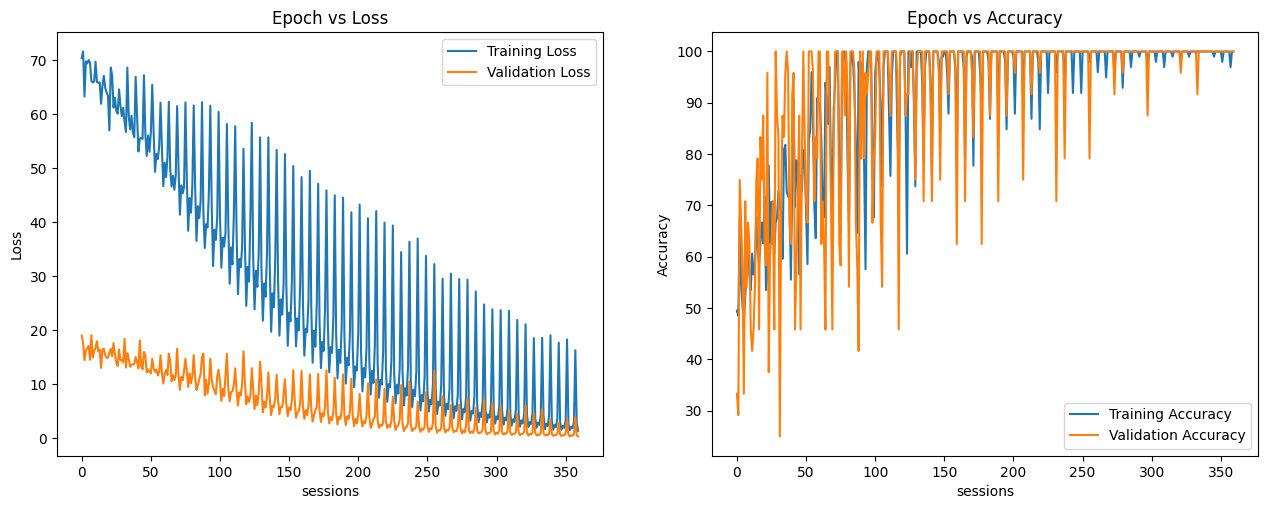

In [11]:
def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('sessions')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('sessions')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc